In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.utils.data import Dataset
from PIL import Image
import random
torch.backends.cudnn.benchmark = True
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split

import random

In [2]:
euroSatLink = "https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1"

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda:0


In [4]:
# Custom dataset class for EuroSAT dataset
class Dataset(Dataset):
    def __init__(self, dataset, path, transform=None):
        self.transform = transform
        self.root_dir = path
        self.data = dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(os.path.join(self.root_dir, img_path)).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

#Get the EuroSAT dataset with specified parameters
def getDataset(path: str, num_classes: int, shuffle_images=True, num_images_per_class = None) -> tuple:
    images_and_labels = []
    class_mapping = {}
    label_counter = 0
    if num_classes > len(os.listdir(path)):
        raise ValueError(f"num_classes ({num_classes}) cannot be greater than the number of classes in the dataset ({len(os.listdir(path))})")
    
    new_list_to_print = []
    categories = random.sample(os.listdir(path), k=num_classes)
    for class_folder in categories:
        class_path = os.path.join(path, class_folder)

        if os.path.isdir(class_path):
            class_mapping[label_counter] = class_folder
            images = os.listdir(class_path)

            if num_images_per_class != None:
                num_images_per_class = int(num_images_per_class)

                if num_images_per_class > len(images):
                    raise ValueError(f"num_images_per_class ({num_images_per_class}) cannot be greater than the number of images in the class ({len(images)})")
                images = random.sample(images, k=num_images_per_class)
                new_list_to_print.append(f"Using {num_images_per_class} images per class {class_folder}")
            label_images = [(os.path.join(class_folder, image), label_counter)
                            for image in images]
            images_and_labels.extend(label_images)
            label_counter += 1
            
    new_list_to_print.sort()
    for str in new_list_to_print:
        print(str)
        
    if shuffle_images:
        random.shuffle(images_and_labels)

    return images_and_labels, class_mapping

# Create DataLoader instances for training and testing datasets
def GetDataSetLoaders(batch_size):
    root_dir = os.path.join(os.getcwd(), 'data/EuroSAT_RGB')
    dataset, _ = getDataset(path=root_dir, num_classes=5, num_images_per_class=20)

    class_images = {i: [] for i in range(5)}

    # Group the images by class
    for image_path, class_label in dataset:
        class_images[class_label].append((image_path, class_label))

    # Initialize the training and test sets
    train_set = []
    test_set = []

    # Select 5 images for training and 15 for testing from each class
    for class_label, images in class_images.items():
        train_set.extend(random.sample(images, k=5))
        test_set.extend(list(set(images) - set(train_set)))


    train_transforms = transforms.Compose(
            [
                transforms.Resize(224),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4, 0.4, 0.5), (0.6, 0.6, 0.6)),
            ]
        )

    test_transforms = transforms.Compose(
            [
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize((0.4, 0.4, 0.5), (0.6, 0.6, 0.6)),
            ]
        )
        
    train_dataset = Dataset(dataset=train_set, path=root_dir, transform=train_transforms)
    test_dataset = Dataset(dataset=test_set, path=root_dir, transform=test_transforms)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    return train_loader, test_loader

In [5]:
# function to evaluate the network
def eval(net, data_loader, criterion=nn.CrossEntropyLoss()):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
    net.eval()
    correct = 0.0
    num_images = 0.0
    loss = 0.0
    for i_batch, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        outs = net(images)
        loss += criterion(outs, labels).item()
        _, predicted = torch.max(outs.data, 1)
        correct += (predicted == labels).sum().item()
        num_images += len(labels)
        print('testing -> batch: %d correct: %d num of images: %d' % (i_batch, correct, num_images) + '\r', end='')
    acc = correct / num_images
    loss /= len(data_loader)
    return acc, loss


# training function
def train(net, train_loader, test_loader, num_epochs, learning_rate, weight_decay):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=(0.5, 0.99))
    scheduler = StepLR(optimizer, step_size=4, gamma=0.001)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()

    training_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        net.train()
        correct = 0.0
        num_images = 0.0
        total_loss = 0.0

        for i_batch, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            output_train = net(images)
            loss = criterion(output_train, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predicts = output_train.argmax(dim=1)
            correct += predicts.eq(labels).sum().item()
            num_images += len(labels)
            total_loss += loss.item()

            print('training -> epoch: %d, batch: %d, loss: %f' % (epoch, i_batch, loss.item()) + '\r', end='')

        print()
        acc = correct / num_images
        acc_test, test_loss = eval(net, test_loader)
        average_loss = total_loss / len(train_loader)
        training_losses.append(average_loss)
        val_losses.append(test_loss)
        print('\nepoch: %d, lr: %f, accuracy: %f, avg. loss: %f, test accuracy: %f test loss: %f\n' % (epoch, optimizer.param_groups[0]['lr'], acc, average_loss, acc_test, test_loss))

        scheduler.step()

    return net, training_losses, val_losses

In [6]:
# Importing the create_model function from the timm library
from timm import create_model
# Definition of model class
class VIT_Model(nn.Module):
    def __init__(self, num_classes):
        super(VIT_Model, self).__init__()
        self.model = create_model('vit_base_patch32_224', pretrained=True)
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)
    # Forward pass through the vision transformer model
    def forward(self, x):
        return self.model(x)

In [7]:
# Setting hyperparameters for the training process
batch_size = 4
learning_rate = 0.00005
weight_decay=0.0005
num_epochs = 5
iterations = 5

total_test_loss = 0.0
total_test_acc = 0.0

# Run the training
for iteration in range(iterations):
    print('--------------------------------------------------------------')
    print(f"Training Iteration: {iteration}")

    loaded_model = torch.load(os.path.join(os.getcwd(), 'ViT_Model_Save.pth'), map_location=device)
    model = VIT_Model(64).to(device)
    model.load_state_dict(loaded_model)
    model.model.head = nn.Linear(model.model.head.in_features, 5).to(device)
    
    # Enabling gradient computation for all parameters in the model
    for param in model.parameters():
        param.requires_grad = True
    train_loader, test_loader = GetDataSetLoaders(batch_size=batch_size)
    model, training_losses, val_losses = train(net=model, train_loader=train_loader, test_loader=test_loader, num_epochs=num_epochs, learning_rate=learning_rate, weight_decay=weight_decay)
    
    # Evaluating the model on the test data
    acc_test, test_loss = eval(model, test_loader)
    total_test_loss += test_loss
    total_test_acc += acc_test
    print('\naccuracy on testing data: %f' % acc_test)
    print('loss on testing data: %f' % test_loss)

print("---------------------------------------------")   
print(f"Average Test Accuracy: {total_test_acc/iterations}")
print(f"Average Test Loss: {total_test_loss/iterations}")

--------------------------------------------------------------
Training Iteration: 0
Using 20 images per class HerbaceousVegetation
Using 20 images per class Industrial
Using 20 images per class Pasture
Using 20 images per class PermanentCrop
Using 20 images per class Residential
training -> epoch: 0, batch: 6, loss: 0.868049
testing -> batch: 18 correct: 33 num of images: 75
epoch: 0, lr: 0.000050, accuracy: 0.200000, avg. loss: 1.862695, test accuracy: 0.440000 test loss: 1.633082

training -> epoch: 1, batch: 6, loss: 0.106310
testing -> batch: 18 correct: 48 num of images: 75
epoch: 1, lr: 0.000050, accuracy: 0.840000, avg. loss: 0.362193, test accuracy: 0.640000 test loss: 0.881535

training -> epoch: 2, batch: 6, loss: 0.064561
testing -> batch: 18 correct: 55 num of images: 75
epoch: 2, lr: 0.000050, accuracy: 1.000000, avg. loss: 0.075573, test accuracy: 0.733333 test loss: 0.761409

training -> epoch: 3, batch: 6, loss: 0.047358
testing -> batch: 18 correct: 57 num of images: 

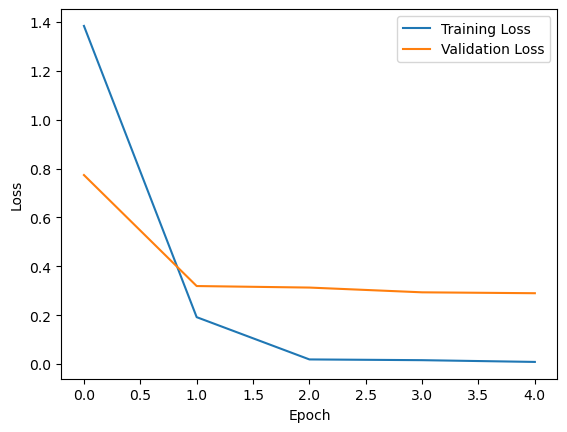

In [8]:
# Plotting training and validation losses over epochs
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.plot(val_losses, label='Validation Loss')
plt.ylabel('Loss')
plt.legend()
plt.show()